## Problem Statement: Churn is difficult to predict. Doing so (accurately) on a monthly basis for the next year will guide Optimizely’s efforts as well as guide how we invest our resources to service segments where we find favorability. 


In [144]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 15)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 15)

from sklearn import linear_model, metrics

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tsa import arima_model
from statsmodels.graphics.tsaplots import plot_acf

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sb

In [22]:
df = pd.read_csv(os.path.join('..', 'datasets', 'C:/Users/tcaballero/DS-SF-30/final-project/Customer Cube - 1.30.17.csv'))
df

,customer_code,for_month,mrr,last_yr,last_mrr,mobile_experiments_started,experiments_started,...,days_overdue,collaborators_added,billing_period,age,contract_start_date,retention,churn_dollars
0,A1,7/1/2016,1000,NaN,NaN,0,1,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
1,A1,8/1/2016,0,NaN,NaN,0,2,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
2,A1,9/1/2016,1000,NaN,NaN,0,2,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
3,A1,10/1/2016,1000,NaN,NaN,0,4,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
4,A1,11/1/2016,1000,NaN,NaN,0,0,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
5,A1,12/1/2016,1000,NaN,NaN,0,0,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
6,A1,1/1/2017,0,NaN,NaN,0,0,...,NaN,1.0,Quarter,38.0,3/9/2016,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62515,A2312,6/1/2016,0,6/1/2015,0.0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN
62516,A2312,7/1/2016,0,7/1/2015,0.0,0,0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
rows = df.shape[0]
cols = df.shape[1]
print "rows = {} and columns = {}".format(rows, cols)
print df.dtypes

rows = 62522 and columns = 39
customer_code                  object
for_month                      object
mrr                             int64
last_yr                        object
last_mrr                      float64
mobile_experiments_started      int64
experiments_started             int64
                               ...   
days_overdue                  float64
collaborators_added           float64
billing_period                 object
age                           float64
contract_start_date            object
retention                     float64
churn_dollars                 float64
dtype: object


In [111]:
## the columns selected below are all time series variables, so I begin by creating a subset of the dataframe to make this data easier to work with

In [4]:
df[[5,6,7,8,9,10,11,12,13,14]].isnull().sum()

mobile_experiments_started    0
experiments_started           0
allocation                    0
utilization                   0
tickets_created               0
impressions                   0
impression_revenue            0
knowledge_base_views          0
logins                        0
sig_exp_90                    0
dtype: int64

In [112]:
#df_sigexp0 = df[['sig_exp_90'==1,'logins']]
df_sigexp = pd.get_dummies(df.sig_exp_90, prefix = 'sig_exp')
#df_sigexp.shape

In [113]:
## If I compare boxplots for sig_exp_90 = 0 vs 1 against number of logins then I can see they have different (and non overlapping)
IQRs, suggesting a statisctially significant difference between the two. 

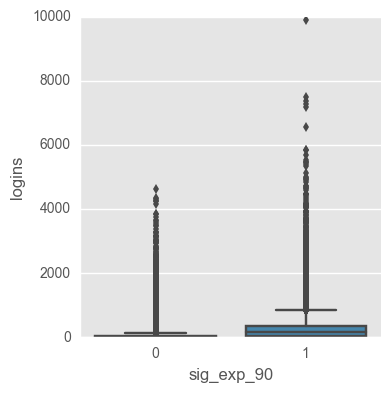

In [93]:
sb.factorplot(x = 'sig_exp_90',
              y = 'logins',
              data = df,
              kind = 'box')

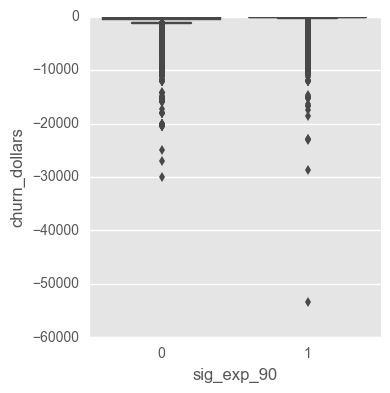

In [88]:
#but the difference is less obvious against my dependent variable: churn dollars
sb.factorplot(x = 'sig_exp_90',
              y = 'churn_dollars',
              data = df,
              kind = 'box')

In [29]:
df.Date = pd.to_datetime(df.for_month) #converts for_month column to date object to allow for time series analysis

0       2016-07-01
1       2016-08-01
2       2016-09-01
3       2016-10-01
4       2016-11-01
5       2016-12-01
6       2017-01-01
           ...    
62515   2016-06-01
62516   2016-07-01
62517   2016-08-01
62518   2016-09-01
62519   2016-10-01
62520   2016-11-01
62521   2016-12-01
Name: for_month, dtype: datetime64[ns]

In [115]:
#compare distribution of values for when sig_exp = 0 vs 1
df.sig_exp_90.value_counts(dropna = False).sort_index()

0    48392
1    14130
Name: sig_exp_90, dtype: int64

In [43]:
pd.crosstab(df.partner_flag, df.sig_exp_90)


sig_exp_90,0,1
partner_flag,,
no,39807,10087
yes,8585,4043


In [117]:
## appears to be some colinearity between these 2 independent variables. I'm looking to explain retention as the final y variable
#sig_exp_check = 0 has twice the range that =1 has.

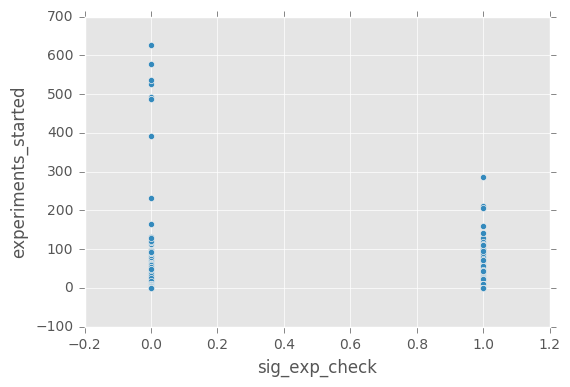

In [10]:
df.plot(kind = 'scatter', x = 'sig_exp_check', y = 'experiments_started')
 

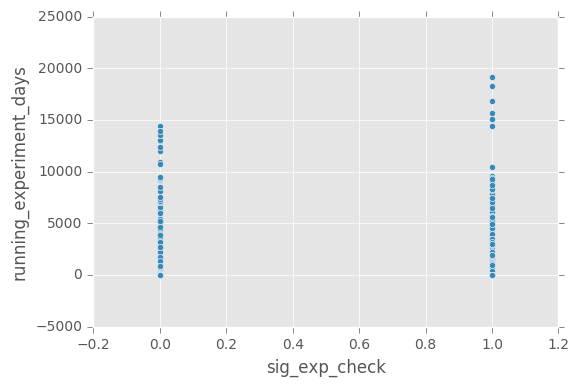

In [11]:
df.plot(kind = 'scatter', x = 'sig_exp_check', y = 'running_experiment_days')

In [94]:
df_sig = df[(df.sig_exp_90 == 1)]
df_sig
#Previous analysis has shown that instances where sig_exp_90 =1 is more meanginful because these are customers who've run an experiment
#that's reached statistical significance inthe past 90 days. 
#So I created a new feature, which filters for when this condition is true and I use this subset of the data for my analysis

,customer_code,for_month,mrr,last_yr,last_mrr,mobile_experiments_started,experiments_started,...,collaborators_added,billing_period,age,contract_start_date,retention,churn_dollars,sig_exp_check
0,A1,7/1/2016,1000,NaN,NaN,0,1,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
1,A1,8/1/2016,0,NaN,NaN,0,2,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
2,A1,9/1/2016,1000,NaN,NaN,0,2,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
3,A1,10/1/2016,1000,NaN,NaN,0,4,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
4,A1,11/1/2016,1000,NaN,NaN,0,0,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
5,A1,12/1/2016,1000,NaN,NaN,0,0,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
6,A1,1/1/2017,0,NaN,NaN,0,0,...,1.0,Quarter,38.0,3/9/2016,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62211,A2247,11/1/2016,9167,NaN,NaN,0,11,...,41.0,NaN,359.0,11/15/2016,NaN,NaN,True
62212,A2247,12/1/2016,9167,NaN,NaN,0,0,...,41.0,NaN,359.0,11/15/2016,NaN,NaN,True


In [95]:
#I compare the above DataFrame to the below one, to show what the inverse of sig_exp_90 looks like
df_not_sig = df[(df.sig_exp_90 == 0)]
df_not_sig

,customer_code,for_month,mrr,last_yr,last_mrr,mobile_experiments_started,experiments_started,...,collaborators_added,billing_period,age,contract_start_date,retention,churn_dollars,sig_exp_check
7,A2,2/1/2013,359,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
8,A2,3/1/2013,3186,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
9,A2,4/1/2013,2988,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
10,A2,5/1/2013,2988,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
11,A2,6/1/2013,2988,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
12,A2,7/1/2013,2988,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
13,A2,8/1/2013,2988,NaN,NaN,0,0,...,92.0,NaN,387.0,4/1/2016,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62515,A2312,6/1/2016,0,6/1/2015,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False
62516,A2312,7/1/2016,0,7/1/2015,0.0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,False


In [129]:
model = smf.ols(formula = 'churn_dollars ~ logins + running_experiment_days + utilization', data = df_sig).fit()
model.summary()
#only utilization and intercept seem to be significant 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          churn_dollars   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     50.96
Date:                Tue, 21 Feb 2017   Prob (F-statistic):           1.16e-32
Time:                        17:38:14   Log-Likelihood:                -82440.
No. Observations:                9291   AIC:                         1.649e+05
Df Residuals:                    9287   BIC:                         1.649e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                -726.0962     22.250    -32.634      0.000      -769.711  -682.481
logins                      0.0644      0.031      2.111      0.035         0.005     0.124
running_experiment_days     0.1994      0.020     10.152      0.000         0.161     0.238
utilization             -1.228e-07   7.91e-06     -0.016      0.988     -1.56e-05  1.54e-05
==============================================================================
Omnibus:                    12519.870   Durbin-Watson:                   1.292
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6257216.824
Skew:                          -7.393   Prob(JB):                         0.00
Kurtosis:                     129.272   Cond. No.                     3.21e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.21e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

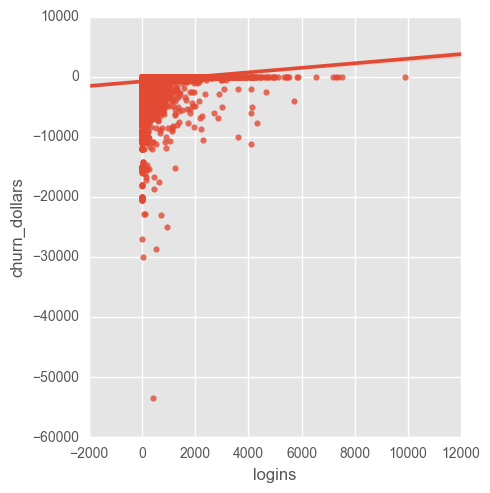

In [106]:
sb.lmplot(x = 'logins', y = 'churn_dollars', data = df)
#clearly some limitations on the boundaries will affect the resutling distribution

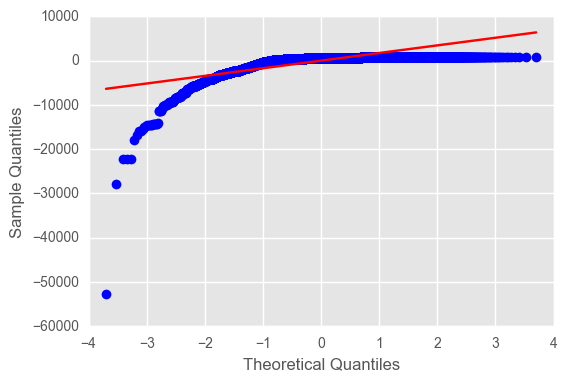

In [107]:
sm.qqplot(model.resid, line = 's')

pass
#VERY NOT NORMALLY DISTRIBUTED. Probably shouldn't continue with regression. 
#anything I can do to change the underlying dataset?

In [146]:
model = smf.ols(formula = 'churn_dollars ~ logins + running_experiment_days + utilization', data = df_not_sig).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          churn_dollars   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     160.6
Date:                Tue, 21 Feb 2017   Prob (F-statistic):          5.67e-103
Time:                        18:27:49   Log-Likelihood:            -1.9205e+05
No. Observations:               21712   AIC:                         3.841e+05
Df Residuals:                   21708   BIC:                         3.841e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                -879.0611     12.440    -70.665      0.000      -903.444  -854.678
logins                      0.5086      0.045     11.274      0.000         0.420     0.597
running_experiment_days     0.1760      0.024      7.376      0.000         0.129     0.223
utilization              4.348e-05   5.65e-06      7.697      0.000      3.24e-05  5.46e-05
==============================================================================
Omnibus:                    19497.696   Durbin-Watson:                   0.479
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           977123.215
Skew:                          -4.198   Prob(JB):                         0.00
Kurtosis:                      34.774   Cond. No.                     2.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

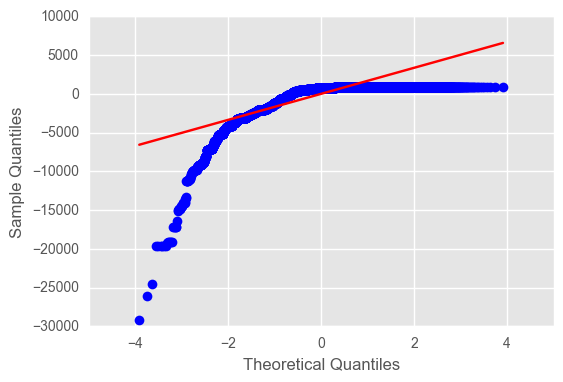

In [147]:
sm.qqplot(model.resid, line = 's')
pass
#this shows the distribution for when sig_exp_90 == 0 is even more non-normal than when it's == 1. CLearly this binary flag
#affects resulting distribution

In [62]:
df_corr = df[[6,7,8,10,11,13,14,16,17,37]]
df_corr.corr()
#logins and experiments started have a 33% correlation
#logins vs running_experiment_days = 40%
#logins vs sig_exp_90 = 30%
#running experiment days vs retention = 20% correlation

,experiments_started,allocation,utilization,impressions,impression_revenue,logins,sig_exp_90,running_experiment_days,retention
experiments_started,1.000000,-0.023898,-0.001045,0.138018,0.063188,0.337929,0.152299,0.529537,0.162483
allocation,-0.023898,1.000000,-0.000452,-0.008128,-0.004573,-0.036485,-0.053734,-0.027774,-0.162396
utilization,-0.001045,-0.000452,1.000000,-0.000317,-0.000160,-0.001558,-0.002158,-0.001258,0.135242
impressions,0.138018,-0.008128,-0.000317,1.000000,0.120721,0.124951,0.079918,0.310563,0.033289
impression_revenue,0.063188,-0.004573,-0.000160,0.120721,1.000000,0.066670,0.045594,0.112141,0.025226
logins,0.337929,-0.036485,-0.001558,0.124951,0.066670,1.000000,0.307443,0.406427,0.175118
sig_exp_90,0.152299,-0.053734,-0.002158,0.079918,0.045594,0.307443,1.000000,0.241872,0.130570
running_experiment_days,0.529537,-0.027774,-0.001258,0.310563,0.112141,0.406427,0.241872,1.000000,0.191506
retention,0.162483,-0.162396,0.135242,0.033289,0.025226,0.175118,0.130570,0.191506,1.000000


In [64]:
#df_sig = when sig_exp_90 = 1
df_sig_corr = df_sig[[6,7,8,10,11,13,16,17,37]].corr()
df_sig_corr
#correlation shoots up to ~60% between running_experiment_days vs experiments_started which makes sense because experiments_started
#is a component of running_experiment_days. Therefore, my model should only use one of these variables, not both
#running experiment days is 40% correlated with Utilization
#Obviously utilization and impression would be highly correlated as well so that makes sense

,experiments_started,allocation,utilization,impressions,impression_revenue,logins,running_experiment_days,retention
experiments_started,1.000000,0.005515,0.259833,0.193187,0.067567,0.365765,0.586635,0.198656
allocation,0.005515,1.000000,-0.006589,-0.004437,-0.002307,-0.009626,-0.001938,-0.063559
utilization,0.259833,-0.006589,1.000000,0.356421,0.061814,0.170038,0.398714,0.105689
impressions,0.193187,-0.004437,0.356421,1.000000,0.118813,0.091926,0.345466,0.029071
impression_revenue,0.067567,-0.002307,0.061814,0.118813,1.000000,0.050293,0.106478,0.027420
logins,0.365765,-0.009626,0.170038,0.091926,0.050293,1.000000,0.320027,0.120760
running_experiment_days,0.586635,-0.001938,0.398714,0.345466,0.106478,0.320027,1.000000,0.188006
retention,0.198656,-0.063559,0.105689,0.029071,0.027420,0.120760,0.188006,1.000000


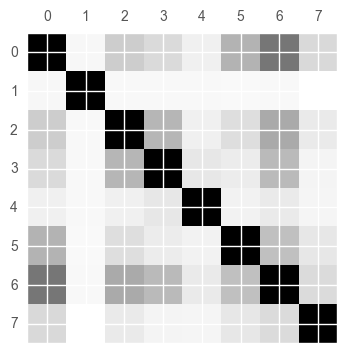

In [76]:
plt.matshow(df_sig_corr)

# shift gocus to try logistic regression and use churn binary flag. Midway through analysis, I changed my data set to add a binary flag indicating if that customer churned in the next month. This allowed me to do logistic regression and work around having NAs

In [134]:
train_df = df_not_sig.sample(frac = .75, random_state = 0)
test_df = df_not_sig.drop(train_df.index)

In [136]:
train_df.columns

Index([u'customer_code', u'for_month', u'mrr', u'last_yr', u'last_mrr',
       u'mobile_experiments_started', u'experiments_started', u'allocation',
       u'utilization', u'tickets_created', u'impressions',
       u'impression_revenue', u'knowledge_base_views', u'logins',
       u'sig_exp_90', u'brand_ops', u'running_experiment_days', u'vertical',
       u'segment', u'country', u'region', u'number_of_employees', u'traffic',
       u'annual_revenue', u'account_potential_score', u'ae', u'csm',
       u'partner_flag', u'first_month', u'last_month', u'last record',
       u'churned', u'days_overdue', u'collaborators_added', u'billing_period',
       u'age', u'contract_start_date', u'retention', u'churn_dollars',
       u'sig_exp_check'],
      dtype='object')

In [137]:
names_X = ['sig_exp_90', 'logins',
    'running_experiment_days', 'utilization']       #, 'churn_dollars']

def X_c(df):
    X = df[ names_X ]
    c = df.churned
    return X, c

train_X, train_c = X_c(train_df)
test_X, test_c = X_c(test_df)

In [138]:
model = linear_model.LogisticRegression().fit(train_X, train_c)

print model.intercept_
print model.coef_

[ -1.04181995e-19]
[[  0.00000000e+00  -4.98537224e-17  -5.41173601e-17   8.35694739e-13]]


In [139]:
model = linear_model.LogisticRegression().fit(test_X, test_c)

print model.intercept_
print model.coef_

[  1.96150448e-05]
[[  0.00000000e+00  -1.01737577e-02   1.37703612e-04  -2.21439336e-07]]


In [140]:
print 'training misclassification =', 1 - model.score(train_X, train_c)
print 'testing  misclassification =', 1 - model.score(test_X, test_c)

training misclassification = 0.253127238662
testing  misclassification = 0.255662092908


In [ ]:
## compare the above classification error results with the scenario for when sig_exp_90 == 1

In [130]:

train_df = df_sig.sample(frac = .75, random_state = 0)
test_df = df_sig.drop(train_df.index)

names_X = ['sig_exp_90', 'logins', 
    'running_experiment_days', 'utilization']       #, 'churn_dollars']

def X_c(df):
    X = df[ names_X ]
    c = df.churned
    return X, c

train_X, train_c = X_c(train_df)
test_X, test_c = X_c(test_df)

In [131]:
model = linear_model.LogisticRegression().fit(train_X, train_c)

print model.intercept_
print model.coef_

[-0.00012863]
[[ -1.28634008e-04  -1.55702611e-02   4.85900172e-05  -2.78730991e-09]]


In [132]:
model = linear_model.LogisticRegression().fit(test_X, test_c)

print model.intercept_
print model.coef_

[-0.00011595]
[[ -1.15948967e-04  -1.42249847e-02   4.01014433e-04   1.02224533e-08]]


In [133]:
print 'training misclassification =', 1 - model.score(train_X, train_c)
print 'testing  misclassification =', 1 - model.score(test_X, test_c)
#errors go down drastically once I focus my efforts on data where sig_exp_90 = 1

training misclassification = 0.119079071523
testing  misclassification = 0.113250283126


In [ ]:
# Conclusions: focusing on when Stat_Sig_90 == 1 really refines the accuracey of my model and lowers my test error. 

# next steps: Do some time series analysis  across variables that have time components. It would be good to incorporate this time series dimension into regression tree so that I can rank each variables significance and see how this ranking changes over time

# another useful next step is to be able to predict how many dollars we will churn in the future